In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Import the pandas library
import pandas as pd

file_name = "month_data.csv"
# Define the file path
file_path = r"../" +"data" + "/" + file_name

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, sep=';', encoding='utf-8')

# Display the first few rows of the DataFrame
#print(df.head())

In [100]:
import numpy as np

specific_date = '2019-03-27'  # Change this to desired date
start_time = '7:00:00' #select peak hours of the day
end_time = '19:00:00'

#filter the dataset to specific date and get a copy
filtered_for_date=df[(df['Datum_PAU']== specific_date)].copy()

#convert planned arrival time and planned departure time to date time format
filtered_for_date['PlanAnkTid'] = pd.to_datetime(filtered_for_date['PlanAnkTid'],errors='coerce')
filtered_for_date['PlanAvgTid'] = pd.to_datetime(filtered_for_date['PlanAvgTid'],errors='coerce')

#filter the dataset for the peak time
filtered_for_date = filtered_for_date[((filtered_for_date['PlanAnkTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAnkTid'].dt.time <= pd.to_datetime(end_time).time())) | 
                                      ((filtered_for_date['PlanAvgTid'].dt.time >= pd.to_datetime(start_time).time()) &
                                      (filtered_for_date['PlanAvgTid'].dt.time <= pd.to_datetime(end_time).time()))]

#filter for the platform
filtered_for_platform= filtered_for_date[(filtered_for_date['Ankomstplats']=='Uppsala c') | ( filtered_for_date['Avgångsplats']=='Uppsala c' )]

#List of unique mission station codes to filter by
unique_missions_for_given_station = ['U', 'Gä', 'Cst','Fln']

#Filter the DataFrame based on starting or ending stations matching the unique mission codes
filtered_for_unique_mission_for_given_station = filtered_for_platform[
    (filtered_for_platform['Förstaplatssignatur_för_Uppdrag'].isin(unique_missions_for_given_station)) &
    (filtered_for_platform['Sistaplatssignatur_för_Uppdrag'].isin(unique_missions_for_given_station))
]

# Extract the unique Tåguppdrag values from the filtered dataset
unique_missions = filtered_for_unique_mission_for_given_station['Tåguppdrag'].unique()

# Display the unique Tåguppdrag values
print("Unique Tåguppdrag for specified stations:", unique_missions)



Unique Tåguppdrag for specified stations: [ 855. 8423. 8428.  845. 8416.   17.  843. 8410.   20. 8408.  823.  836.
  825.  846. 8420.   13.  815.  882.  841.  895. 8461.  271.  894.  896.
  838.  893.  857.   19.  848.  853.  816.  808. 8457. 8450.  828. 8455.
  891.  812.  859.  881. 8431.  829.   14.   22.  806.  827. 8463.  818.
 8424. 8436. 8446. 8451.  887. 8435.  822.   64.  833.  884.  889.  892.
 8417.  831.  890.  817. 8432.  883. 8459.  280. 8419.  839.  837.  826.
  824. 8440. 8412.  819. 8442.  849. 8447. 8448.  820.  814.  821.   51.
 8421.  840.  835. 8201.  844.  842. 8444. 8425.  834.  851.  813. 8443.
 8452.  852.  810.  830.  832.  850. 8427. 8439.]


In [ ]:

import pandas as pd

#excluding train missions as they do not show Första or Sista
excluded_missions= [13,51,882,806,8417,8419]

# List of specific mission types interested in
mission_types = unique_missions[~np.isin(unique_missions, excluded_missions)]

# Initialize a dictionary to hold routes for each mission
all_routes = {}
all_filtered_rows = []  # List to store rows used to generate the routes

# Loop through each mission type
for mission_type in mission_types:
    # Initialize a list to hold the routes for the current mission
    routes = []

    # Step 4: Iterate through the DataFrame to build routes
    for index, row in filtered_for_date.iterrows():
        if row['UppehållstypAvgång'] == 'Första' and row['Tåguppdrag'] == mission_type:
            # Start the route with the departure station
            current_route = [row['Avgångsplats']]
            all_filtered_rows.append(row)  # Save the current row to the list
            next_row = row

            # Add the arrival station of the "Första" row to the route as the next stop
            current_route.append(next_row['Ankomstplats'])
             
            # Continue to add stations until reaching 'Sista'
            while next_row['UppehållstypAnkomst'] != 'Sista':
                # Find the next station in the DataFrame that matches the current departure station
                next_station = filtered_for_date[(filtered_for_date['Avgångsplats'] == next_row['Ankomstplats']) &
                                  (filtered_for_date['Tåguppdrag'] == mission_type)]
                

                if not next_station.empty:
                    next_stop = next_station.iloc[0]['Ankomstplats']
                    current_route.append(next_stop)
                    all_filtered_rows.append(next_station.iloc[0])  # Save the row to the list
                    next_row = next_station.iloc[0]  # Move to the next row

                else:
                    break  # Exit if no further stations are found

            # If the last station is 'Sista', append it to the route
            if next_row['UppehållstypAnkomst'] == 'Sista' and next_row['Ankomstplats'] != current_route[-1]:
                current_route.append(next_row['Ankomstplats'])

            # Add the complete route to the routes list
            routes.append(" -> ".join(current_route))

    # Store the routes for the current mission in the dictionary
    all_routes[mission_type] = routes

# Save the filtered rows used to generate the routes into a new DataFrame
filtered_rows_df = pd.DataFrame(all_filtered_rows)



In [103]:
import preprocessing

In [104]:
preprocessing.create_ids(filtered_rows_df)
preprocessing.missing_utfAvgTid(filtered_rows_df)


------Missing values filled------
total missing values in UtfAvgTid 14
total missing values in UtfAnkTid 0
after update total nan avg values are  0
after update total nan ank values are  0






In [ ]:
#Descriptive statistic of test network
print('Number of unique train missions used for test network: ',len(filtered_rows_df['Tåguppdrag'].unique()))


#total records included in the test network
print('Number of totla records in the test network:',len(filtered_rows_df))

#number of unique depature stations
print('Number of unique depature stations in the test network:',len(filtered_rows_df['Avgångsplats'].unique()))

#number of unique arrival stations
print('Number of unique arrival stations in the test network:',len(filtered_rows_df['Ankomstplats'].unique()))

#number of unique routes
print('Number of unique routes available in the test network:',len(filtered_rows_df[['Ankomstplats','Avgångsplats']].drop_duplicates()))

#number of depature delays
#print('Number of depature delays:',len(filtered_rows_df[filtered_rows_df['AvgFörsening'] > 0].dropna(subset=['AvgFörsening'])))

#maximum depature delay across all routes
print('Maximum depature delay from a station across all routes(minutes):', max(filtered_rows_df['AvgFörsening'] ))

#early depature across all routes
print('Maximum early depature from a station across all routes(minutes):',min(filtered_rows_df['AvgFörsening']))

#number of arrival delays
#print('Number of arrival delays:',len(filtered_rows_df[filtered_rows_df['AnkFörsening']>0].dropna(subset=['AnkFörsening'])))

#maximum arrival delay across all routes
print('Maximum arrival delay to a station across all routes(minutes):', max(filtered_rows_df['AnkFörsening'] ))

#early arrival across all routes
print('Maximum early arrival to a station across all routes(minutes):',min(filtered_rows_df['AnkFörsening']))

#Number of edges delay in travel time
#print('Number of edges delay in travel time: ', len(filtered_rows_df[filtered_rows_df['FörseningUppehållAvgång']>0]))

#maximum travel time delay across edges
print('Maximum travel time delay within edges:',max(filtered_rows_df['FörseningUppehållAvgång'].dropna()))

#Number of trains with no delays
no_delay_count = len(filtered_rows_df[
            (filtered_rows_df['AnkFörsening']<=0) & 
             (filtered_rows_df['AvgFörsening']<=0) & 
             (filtered_rows_df['FörseningUppehållAvgång']<=0)
             ]
             )
#print('Number of trains with no delays:',no_delay_count)

Number of unique train missions used for test network:  98
Number of totla records in the test network: 2087
Number of unique depature stations in the test network: 76
Number of unique arrival stations in the test network: 76
Number of unique routes available in the test network: 141
Maximum depature delay from a station across all routes(minutes): 33.0
Maximum early depature from a station across all routes(minutes): -7.0
Maximum arrival delay to a station across all routes(minutes): 33.0
Maximum early arrival to a station across all routes(minutes): -4.0
Number of edges delay in travel time:  382
Maximum travel time delay within edges: 10.0
Number of trains with no delays: 831


In [107]:


# Save the DataFrame to a CSV file
output_rows_file_name = 'test_network_week_45_bigger.csv'
filtered_rows_df.to_csv('../data/' + output_rows_file_name, index=False, encoding='utf-8-sig')


# Display the routes for each mission
for mission, routes in all_routes.items():
    print(f"\nRoutes for {mission}:")
    for route in routes:
        print("Route:", route)




Routes for 855.0:
Route: Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Märsta -> Brista -> Rosersberg -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -> Helenelund -> Ulriksdal -> Solna -> Tomteboda övre -> Karlberg -> Stockholm C

Routes for 8423.0:
Route: Gävle c -> Bomansberget -> Furuvik -> Skutskär -> Älvkarleby -> Marma norra -> Marma -> Mehedeby -> Orrskog -> Tierp -> Skärpan -> Tobo -> Örbyhus -> Järlebo -> Skyttorp -> Salsta -> Vattholma -> Storvreta -> Samnan -> Uppsala c

Routes for 8428.0:
Route: Uppsala c -> Samnan -> Storvreta -> Vattholma -> Salsta -> Skyttorp -> Järlebo -> Örbyhus -> Tobo -> Skärpan -> Tierp -> Orrskog -> Mehedeby -> Marma -> Marma norra -> Älvkarleby -> Skutskär -> Furuvik -> Bomansberget -> Gävle c

Routes for 845.0:
Route: Uppsala c -> Säby -> Ekeby -> Knivsta -> Myrbacken -> Märsta -> Brista -> Rosersberg -> Skavstaby -> Upplands Väsby -> Rotebro -> Norrviken -> Häggvik -> Sollentuna -> Kummelby -

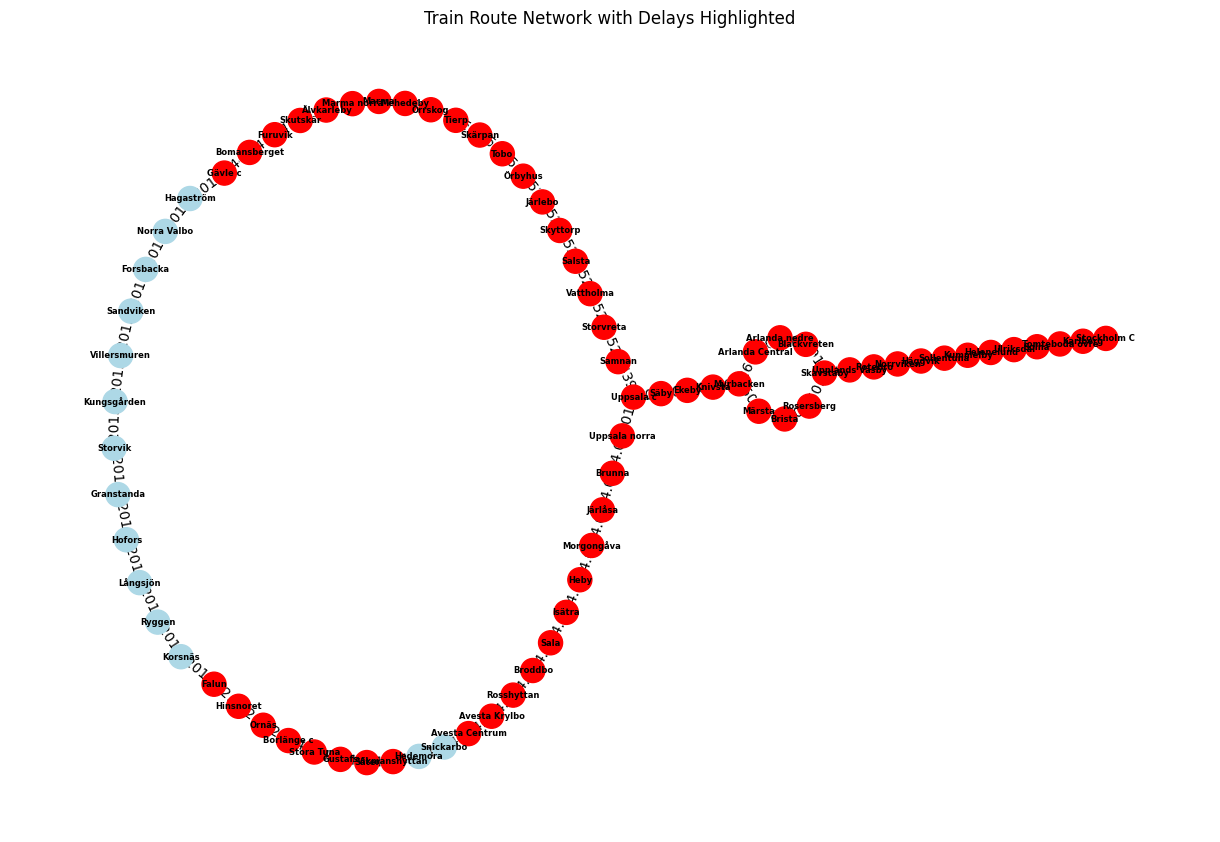

In [108]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `filtered_for_date` contains your dataset and has columns like 'Ankomstplats', 'Avgångsplats', 'AnkFörsening', 'AvgFörsening'

# Calculate total delay for each station
station_delays = {}

# Loop through each row in the dataset to gather delays
for index, row in filtered_rows_df.iterrows():
    station = row['Ankomstplats'] #extract the station name from the colum Ankomsplats
    delay = row['AvgFörsening'] if pd.notnull(row['AvgFörsening']) else 0  #check the arrival delay in the dataframe.
    
    if station not in station_delays:
        station_delays[station] = 0 #initialize empty list to store delay values for that station
    
    station_delays[station] += delay #build list of delay values for each station
    


# Identify stations with delay (total delay > 0)
delayed_stations = [station for station, total_dealy in station_delays.items() if total_dealy > 0]

# Create the network graph
G = nx.DiGraph()

# Add edges for each route
for mission, routes in all_routes.items():
    for route in routes:
        stations = route.split(" -> ")
        for i in range(len(stations) - 1):
            G.add_edge(stations[i], stations[i + 1], mission=mission)

# Draw the graph with highlighted delayed stations
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(G)  # positions for all nodes

# Color nodes: red for delayed stations, light blue for others
node_colors = ["red" if station in delayed_stations else "lightblue" for station in G.nodes()]

nx.draw(G, pos, with_labels=True, node_size=300, node_color=node_colors, font_size=6, font_weight="bold", edge_color="gray", arrows=True)

# Show edge labels for mission types
edge_labels = nx.get_edge_attributes(G, 'mission')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Train Route Network with Delays Highlighted")
plt.show()
